# Simple NMOR examples #

The goal of this notebook is to show how Rydiqule can be used to define and solve atomic systems that exhibit Nonlinear Magneto-Optical Rotation (NMOR).
These systems generally involve a single optical field coupling two hyperfine states with an applied axial magnetic field that breaks the degeneracy of the magnetic sublevels.

As such, an accurate model includes all sublevels of each transition, with the optical coupling being applied to the sub-levels according to the appropriate Clebsch-Gordon coefficients. This is accomplished by using rydiqule's coupling groups functionality with an appropriate clebsch-gordon coefficient dictionary mapping.

One must also be able to apply Larmor shifts to the magnetic sublevels due to the interaction with the magnetic field. This is accomplished by applying energy shifts to each sublevel of a manifold, using a similar dictionary mapping for the energy shift of each state.

The below examples all use the `Sensor` class. This class is largely un-aware of atomic physics, so it is up to the user to specify the correct couplings and interactions when modeling a system.

This notebook can be downloaded [here](https://github.com/QTC-UMD/rydiqule/blob/main/docs/source/examples/NMOR_examples.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext line_profiler

In [3]:
import numpy as np
import itertools
import rydiqule as rq
from arc import CG
import matplotlib.pyplot as plt

## A F=0 to F'=1 spectroscopy experiment with $\sigma^{\pm}$ probing light ##

This example assumes a fixed axial magnetic field and shows the spectroscopic response versus probe detuning.

In [4]:
g = ('g', 0)
e = ('e', [-1,0,1])

In [5]:
s = rq.Sensor([g, e])

In [6]:
dets = np.linspace(-10,10,21)
rabi_freq = 1
cg = {(g, ('e',-1)):1,
      (g, ('e', 0)):0,
      (g, ('e', 1)):-1}

s.add_coupling((g, e), rabi_frequency=rabi_freq, detuning=2*np.pi*dets, coupling_coefficients=cg, label='probe')

In [7]:
s.add_decoherence((e, g), 2*np.pi*6.0666, label='F1_gamma')

In [8]:
larmor_freq = 3
larmor_shifts = {('e', -1): 2*np.pi*larmor_freq,
                 ('e', 1): -2*np.pi*larmor_freq}

s.add_energy_shifts(larmor_shifts)

Note that `Sensor.add_coupling` has automatically zipped together all of the individual couplings detunings' for the detuning sweep.
So there is only one parameter dimension in the generated hamiltonians (instead of two).

In [9]:
hams = s.get_hamiltonian()
print(hams.shape)

(21, 4, 4)


In [10]:
solF0F1sig = rq.solve_steady_state(s)

Full characterization of an optical field requires four parameters. We prefer the angle-ellipticity parameterization where the field is described by its amplitude, phase, linear polarization angle, and ellipticity. Rydiqule's built-in `coupling_coefficient_observable` uses the defined coupling-coefficients for the desired transition to define the susceptibility of the ensemble that is co-polarized with the input light field. This susceptibility then directly gives the field fractional absorption as well as the phase shift. 

To obtain the polarization rotation and ellipticity changes, one must calculate the susceptibility for the orthogonal ensemble polarizability. This is done by providing the coupling-coefficient matrix that corresponds to the orthogonally polarized light field. In this example, this matrix happens to be the absolute value of the co-polarized matrix.

In [11]:
aligned_obs = solF0F1sig.coupling_coefficient_matrix((g, ('e', 'all')))
print(aligned_obs)
perp_obs = np.abs(aligned_obs)
print(perp_obs)

[[ 0.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [-1.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [12]:
susc = solF0F1sig.coupling_coefficient_observable((g, ('e', 'all')))
susc_perp = solF0F1sig.get_observable(perp_obs)

Text(0.5, 0, 'Probe Detuning (MHz)')

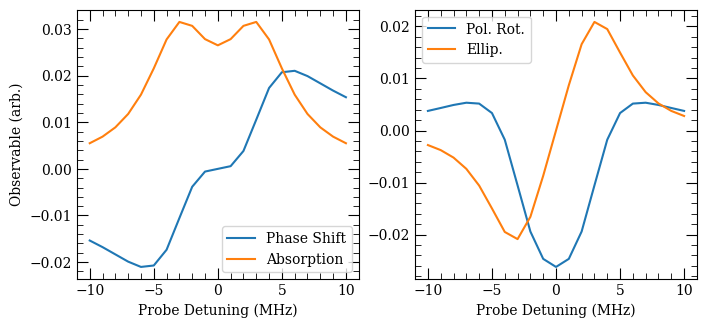

In [13]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))

ax.plot(dets, susc.real, label='Phase Shift')
ax.plot(dets, susc.imag, label='Absorption')
ax.legend()
ax.set_xlabel('Probe Detuning (MHz)')
ax.set_ylabel('Observable (arb.)')

ax2.plot(dets, susc_perp.real, label='Pol. Rot.')
ax2.plot(dets, susc_perp.imag, label='Ellip.')
ax2.legend()
ax2.set_xlabel('Probe Detuning (MHz)')

## A F=0 to F'=1 spectroscopy experiment with $\pi$ polarized probe light ##

This example is nearly identical to the first example, but the light is now $\pi$ polarized (meaning the quantization axis has changed to be aligned with the optical polarization).
Here the observable corresponds to the phase shift on the light.

In [14]:
g = ('g', 0)
e = ('e', [-1,0,1])

In [15]:
s = rq.Sensor([g,e])

In [16]:
dets = np.linspace(-10,10,21)
rabi_freq = 1
cg = {(g, ('e',-1)):0,
      (g, ('e', 0)):1,
      (g, ('e', 1)):0}

s.add_coupling((g,e), rabi_frequency=2*np.pi*rabi_freq, detuning=2*np.pi*dets, coupling_coefficients=cg, label='probe')

In [17]:
s.add_decoherence((e,g), 2*np.pi*6.0666, label='F1_gamma')

In [18]:
solF0F1pi = rq.solve_steady_state(s)

In [19]:
susc = solF0F1pi.coupling_coefficient_observable((g, ('e', 'all')))

Text(0, 0.5, 'Phase shift (arb.)')

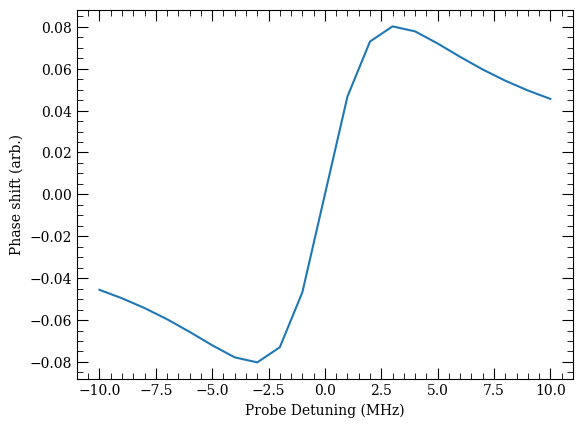

In [20]:
fig, ax = plt.subplots(1)

ax.plot(dets, susc.real)
ax.set_xlabel("Probe Detuning (MHz)")
ax.set_ylabel("Phase shift (arb.)")

## A F=1 to F'=0 spectroscopy experiment with $\sigma^{\pm}$ and a static axial magnetic field ##

This is much like the first example, but the degeneracy of the hyperfine manifolds is reversed between the ground and excited states.
In order for this system to produce an interesting result, we add transit broadening.
This prevents all the population from being optically pumped into the $F=1, m_F=0$ ground state.

In [21]:
g = (1, [-1,0,1])
e = (0, 0)

In [22]:
s = rq.Sensor([g,e])

In [23]:
dets = np.linspace(-10,10,21)
rabi_freq = 1
cg = {((1,-1), e):1,
      ((1,0), e):0,
      ((1,1), e):-1}

s.add_coupling((g,e), rabi_frequency=2*np.pi*rabi_freq, detuning=2*np.pi*dets, coupling_coefficients=cg, label='probe')

In [24]:
cgg = {(e, (1,-1)): 1/3,
       (e, (1,0)): 1/3,
       (e, (1,1)): 1/3}
s.add_decoherence((e, g), 2*np.pi*6.0666, coupling_coefficients=cgg, label='F0_gamma')

s.add_transit_broadening(2*np.pi*0.1, repop={state:1/3 for state in s.states_with_spec(g)})

In [25]:
larmor_freq = 3
prefactors = {(1,-1): 2*np.pi,
              (1,1): -2*np.pi}

s.add_energy_shift(g, larmor_freq, prefactors=prefactors)

In [26]:
solF1F0sig = rq.solve_steady_state(s)

In [27]:
aligned_obs = solF1F0sig.coupling_coefficient_matrix(((1, 'all'), e))
perp_obs = np.abs(aligned_obs)

In [28]:
susc_aligned = solF1F0sig.coupling_coefficient_observable(((1, 'all'), e))
susc_perp = solF1F0sig.get_observable(perp_obs)

In [29]:
pops = rq.get_rho_populations(solF1F0sig)

Text(0, 0.5, 'Sub-level population (frac.)')

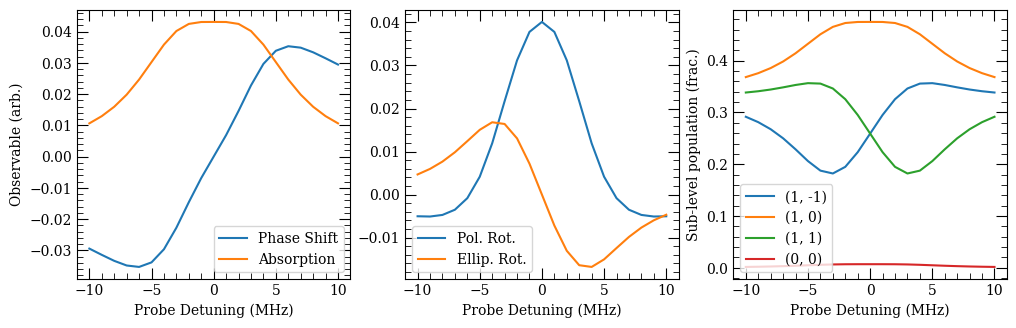

In [30]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5))

ax.plot(dets, susc_aligned.real, label='Phase Shift')
ax.plot(dets, susc_aligned.imag, label='Absorption')
ax.legend()
ax.set_xlabel('Probe Detuning (MHz)')
ax.set_ylabel('Observable (arb.)')

ax2.plot(dets, susc_perp.real,label='Pol. Rot.')
ax2.plot(dets, susc_perp.imag, label='Ellip. Rot.')
ax2.legend()
ax2.set_xlabel('Probe Detuning (MHz)')

ax3.plot(dets, pops, label=s.states)
ax3.legend()
ax3.set_xlabel('Probe Detuning (MHz)')
ax3.set_ylabel('Sub-level population (frac.)')

## A F=1 to F'=0 spectroscopy experiment with $\sigma^{\pm}$ and a static detuning and a varying axial magnetic field ##

This is the prototypical NMOR experiment.
A linearly-polarized probing field interacts with the atomic system.
The quantization axis is aligned with the axial magnetic field, meaning the probing light is decomposed into equal parts of left and right circular polarization.
Sweeping the axial magnetic field strength produces nested dispersive features in the polarization rotation of the probe field.
The larger feature is linear birefringence due to un-even absorption of the two polarization components.
The narrow feature is NMOR, resulting from a non-linear interaction 

In [31]:
g = (1, [-1,0,1])
e = (0, 0)

In [32]:
s = rq.Sensor([g,e])

In [33]:
det = 3
rabi_freq = 1
cg = {((1,-1), e):1,
      ((1,0), e):0,
      ((1,1), e):-1}

s.add_coupling((g,e), rabi_frequency=2*np.pi*rabi_freq, detuning=2*np.pi*det, coupling_coefficients=cg, label='probe')

In [34]:
cgg = {(e, (1,-1)): 1/3,
       (e, (1,0)): 1/3,
       (e, (1,1)): 1/3}
s.add_decoherence((e, g), 2*np.pi*6.0666, coupling_coefficients=cgg, label='F0_gamma')

s.add_transit_broadening(2*np.pi*0.1, repop={state:1/3 for state in s.states_with_spec(g)})

In [35]:
larmor_freqs = np.linspace(-15, 15, 301)
prefactors = {(1,-1): 2*np.pi,
              (1,1): -2*np.pi}

s.add_energy_shift(g, larmor_freqs, prefactors=prefactors)

In [36]:
solF1F0sigNMOR = rq.solve_steady_state(s)

In [37]:
aligned_obs = solF1F0sigNMOR.coupling_coefficient_matrix(((1, 'all'), e))
print(aligned_obs)
perp_obs = np.abs(aligned_obs)
print(perp_obs)

[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  0. -1.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 1. 0.]]


In [38]:
susc_aligned = solF1F0sigNMOR.coupling_coefficient_observable(((1, 'all'), e))
susc_perp = solF1F0sigNMOR.get_observable(perp_obs)

In [39]:
pops = rq.get_rho_populations(solF1F0sigNMOR)

Text(0, 0.5, 'Sub-level population (frac.)')

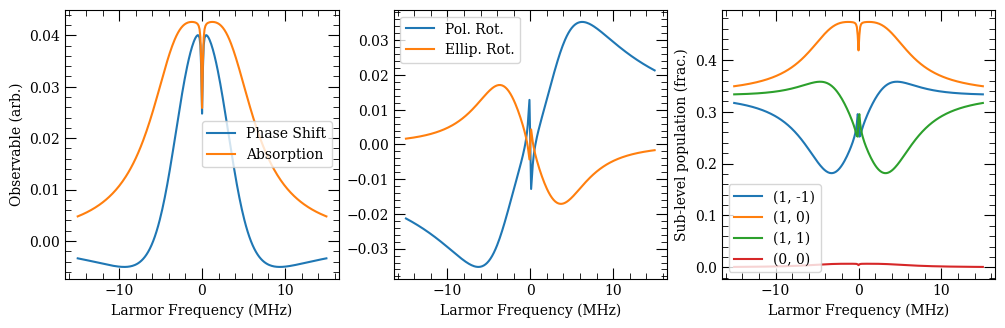

In [40]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5))

ax.plot(larmor_freqs, susc_aligned.real, label='Phase Shift')
ax.plot(larmor_freqs, susc_aligned.imag, label='Absorption')
ax.legend()
ax.set_xlabel('Larmor Frequency (MHz)')
ax.set_ylabel('Observable (arb.)')

ax2.plot(larmor_freqs, susc_perp.real,label='Pol. Rot.')
ax2.plot(larmor_freqs, susc_perp.imag, label='Ellip. Rot.')
ax2.legend()
ax2.set_xlabel('Larmor Frequency (MHz)')

ax3.plot(larmor_freqs, pops, label=s.states)
ax3.legend()
ax3.set_xlabel('Larmor Frequency (MHz)')
ax3.set_ylabel('Sub-level population (frac.)')

## A Rb87 D2 spectroscopy experiment with $\sigma^{\pm}$ polarized light ##

This is equivalent to doing D2 spectroscopy of atoms in a cold beam of Rubidium87 atoms.
The transit of the beam prevents all the atoms from being trivially optically pumped to the stretch state.

To do this correctly, we need to properly scale Rabi frequencies and dephasings by the actual Clebsch-Gordon coefficient for each sub-level transition.

We leverage ARC's implementation to provide this functionality here.

`CG(F, mF, 1, q, F', mF')`

In [41]:
Fps = [0,1,2,3]
Fgs = [1,2]
e_states = [[('e',F,mF) for mF in range(-F,F+1)] for F in Fps]
print(e_states)
g_states = [[('g',F,mF) for mF in range(-F,F+1)] for F in Fgs]
print(g_states)
e_spec = ('e','all','all')
g_spec = ('g','all','all')

[[('e', 0, 0)], [('e', 1, -1), ('e', 1, 0), ('e', 1, 1)], [('e', 2, -2), ('e', 2, -1), ('e', 2, 0), ('e', 2, 1), ('e', 2, 2)], [('e', 3, -3), ('e', 3, -2), ('e', 3, -1), ('e', 3, 0), ('e', 3, 1), ('e', 3, 2), ('e', 3, 3)]]
[[('g', 1, -1), ('g', 1, 0), ('g', 1, 1)], [('g', 2, -2), ('g', 2, -1), ('g', 2, 0), ('g', 2, 1), ('g', 2, 2)]]


In [42]:
# this flattens the list of lists
e_list = list(itertools.chain.from_iterable(e_states))
g_list = list(itertools.chain.from_iterable(g_states))

In [43]:
s = rq.Sensor(g_list+e_list)
print(s.states)
print(f'There are {len(s.states):d} total states')

[('g', 1, -1), ('g', 1, 0), ('g', 1, 1), ('g', 2, -2), ('g', 2, -1), ('g', 2, 0), ('g', 2, 1), ('g', 2, 2), ('e', 0, 0), ('e', 1, -1), ('e', 1, 0), ('e', 1, 1), ('e', 2, -2), ('e', 2, -1), ('e', 2, 0), ('e', 2, 1), ('e', 2, 2), ('e', 3, -3), ('e', 3, -2), ('e', 3, -1), ('e', 3, 0), ('e', 3, 1), ('e', 3, 2), ('e', 3, 3)]
There are 24 total states


We iterate through all optical couplings, ignoring those that are not dipole allowed (ie CG=0).

In [44]:
qs = [-1, 1]
cg = {(('g',Fg,mFg), ('e',Fe,mFe)): CG(Fg, mFg, 1, q, Fe, mFe)**2
      for Fg in Fgs
      for Fe in Fps
      for mFg in range(-Fg,Fg+1)
      for mFe in range(-Fe, Fe+1)
      for q in qs
      if CG(Fg, mFg, 1, q, Fe, mFe) != 0.0}
print(f'There are {len(cg):d} total couplings')

There are 36 total couplings


In [45]:
dets = np.linspace(-310, 205, 231)
rabi_freq = 1

s.add_coupling((g_spec, e_spec), rabi_frequency=2*np.pi*rabi_freq, detuning=2*np.pi*dets, coupling_coefficients=cg, label='probe')

We iterate through all possible dephasing paths (including those that don't have optical couplings on them), again ignoring those that are not dipole-allowed.

In [46]:
qs = [-1, 0, 1]
cgg = {(('e',Fe,mFe), ('g',Fg,mFg)): CG(Fg, mFg, 1, q, Fe, mFe)**2
       for Fg in Fgs
       for Fe in Fps
       for mFg in range(-Fg,Fg+1)
       for mFe in range(-Fe, Fe+1)
       for q in qs
       if CG(Fg, mFg, 1, q, Fe, mFe) != 0.0}
print(f'There are {len(cgg):d} total lifetime dephasings')

There are 54 total lifetime dephasings


In [47]:
s.add_decoherence((e_spec,g_spec), 2*np.pi*6.0666, coupling_coefficients=cgg, label='HFS_gamma')

We add some minor transit broadening. In a doppler-free solution, this would be equivalent to a cold beam of atoms with a transit time through the beams equivalent to 100kHz.

In [48]:
s.add_transit_broadening(2*np.pi*0.1, repop={state: 1/len(g_list) for state in g_list})

We now add the hyperfine shifts of the various manifolds. The excited state is defined relative to the center of mass energy (i.e. fine structure only).
The ground states are defined relative to our primary state of interest.

In [49]:
hfs_shifts = {**{state: 2*np.pi*193.7407 for state in s.states_with_spec(('e',3,'all'))},
             **{state: -2*np.pi*72.9112 for state in s.states_with_spec(('e',2,'all'))},
             **{state: -2*np.pi*229.8518 for state in s.states_with_spec(('e',1,'all'))},
             **{state: -2*np.pi*302.0738 for state in s.states_with_spec(('e',0,'all'))},
             **{state: -2*np.pi*6834.682610904290 for state in s.states_with_spec(('g',1,'all'))}
             }

In [50]:
s.add_energy_shifts(hfs_shifts)

In [51]:
%%time
solRb87D2 = rq.solve_steady_state(s)

CPU times: total: 33.2 s
Wall time: 8.66 s


In [52]:
susc = solRb87D2.coupling_coefficient_observable((e_spec, g_spec))

Text(0, 0.5, 'Probe Absorption (arb.)')

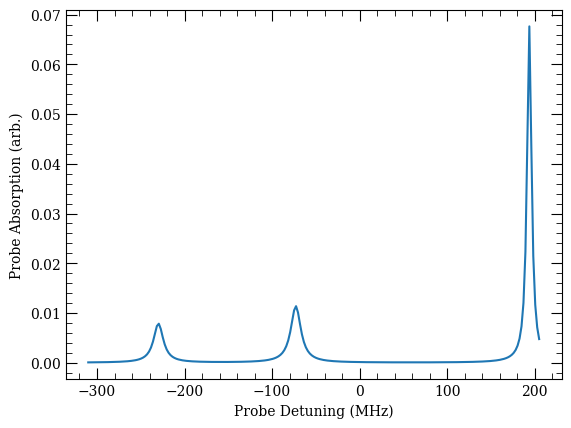

In [53]:
fig, ax = plt.subplots(1)

ax.plot(dets, susc.imag)
ax.set_xlabel('Probe Detuning (MHz)')
ax.set_ylabel('Probe Absorption (arb.)')

In [54]:
rq.about()


        Rydiqule
    
Rydiqule Version:     1.3.0.dev474+g005aa83.d20241205
Installation Path:    ~\src\rydiqule\src\rydiqule

      Dependencies
    
NumPy Version:        1.26.4
SciPy Version:        1.10.1
Matplotlib Version:   3.7.1
ARC Version:          3.6.0
Python Version:       3.11.5
Python Install Path:  ~\miniconda3\envs\rq
Platform Info:        Windows (AMD64)
CPU Count and Freq:   16 @ 3.91 GHz
Total System Memory:  256 GB
